## 3 classes

In [ ]:
import lib_tree
import ser
import strut
import copy
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, f1_score

In [93]:
Final_Data_S1= pd.read_csv("final_H358.csv")
Final_Data_S2= pd.read_csv("final_H355.csv")
Final_Data_S1.loc[Final_Data_S1[Final_Data_S1.labels.isin([ 3.0,4.0])].index, 'labels']=2.0
Final_Data_S2.loc[Final_Data_S2[Final_Data_S2.labels.isin([ 3.0,4.0])].index, 'labels']=2.0
ys = Final_Data_S1.labels
Xs= Final_Data_S1.drop(['Time', 'labels'], axis=1)
yt = Final_Data_S2.labels
Xt= Final_Data_S2.drop(['Time', 'labels'], axis=1)
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(Xt, yt, test_size=0.85, stratify=yt, random_state = 42)
X_train_t = X_train_t.to_numpy()
y_train_t= y_train_t.to_numpy()
N_EST = 3
MAX=3
rf_or = RandomForestClassifier(n_estimators=N_EST, max_depth=MAX)
rf_or.fit(Xs, ys)
rftl= ser.SER_RF(rf_or, X_train_t, y_train_t, original_ser=True)
rf_strut = strut.STRUT_RF(rf_or, X_train_t, y_train_t)


In [94]:
ypredMIX = np.empty(len(y_test_t))

for p in range(len(y_test_t)):
    PSER = ser.forest_posterior(rftl, np.array(X_test_t.iloc[p]).reshape(1, -1)).mean(axis=0)
    PSTRUT = strut.forest_posterior(rf_strut, np.array(X_test_t.iloc[p]).reshape(1, -1)).mean(axis=0)
    PMIX = np.array((PSER,PSTRUT))
    ypredMIX[p] = np.argmax(PMIX.mean(axis=0))

In [79]:
mix_accuracy = accuracy_score(y_test_t, ypredMIX)
print('mix_accuracy:', mix_accuracy)
from sklearn.metrics import precision_recall_fscore_support as score1
precision, recall, fscore, support = score1(y_test_t, ypredMIX)
f1_weighted = f1_score( y_test_t, ypredMIX,  average='weighted')
print('weighted f1 score:', f1_weighted)
print('precision:', precision)
print('recall;', recall)
print('fscore:', fscore)
print('support:', support)
cm = confusion_matrix(y_test_t, ypredMIX)
print("Confusion Matrix ser original:")
print(cm)

mix_accuracy: 0.8744493392070485
weighted f1 score: 0.8712084436814858
precision: [0.94477612 0.64444444 0.77586207]
recall; [0.96493902 0.71165644 0.50561798]
fscore: [0.95475113 0.67638484 0.6122449 ]
support: [656 163  89]
Confusion Matrix ser original:
[[633  23   0]
 [ 34 116  13]
 [  3  41  45]]


Micro-averaged One-vs-Rest ROC AUC score:
0.8901
Macro-averaged One-vs-Rest ROC AUC score:
0.7739


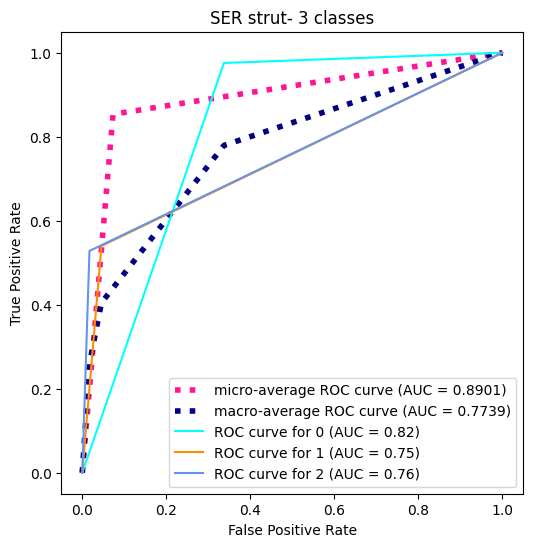

In [96]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay
label_binarizer = LabelBinarizer().fit(y_test_t)
y_onehot_test = label_binarizer.transform(y_test_t)
y_onehot_test.shape  # (n_samples, n_classes)
label_binarizer.transform([0])

import matplotlib.pyplot as plt

y_pred_onehot = label_binarizer.transform(ypredMIX)



from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))


from sklearn.metrics import auc, roc_curve
n_classes = 3
# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_pred_onehot.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.4f}")
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.4f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_pred_onehot[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.4f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.4f}")
colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(3), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_pred_onehot[:, class_id],
        name=f"ROC curve for {class_id}",
        color=color,
        ax=ax,
        #plot_chance_level=(class_id == 2),
    )

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SER strut- 3 classes")
plt.legend()
plt.show()